# Building Taxi Fare Prediction using SageMaker 

<p>This demo notebook guides through the steps in creating an AWS Sagemaker predictions service</p>
<p>To start using Sagemaker go here: <a href="https://aws.amazon.com/sagemaker/">Sagemaker</a></p>

## Read the whole data from S3

In [2]:
import pandas as pd
import os

In [3]:
bucket = '<YOUR BUCKET NAME>'
path = 'data/train/'
filename = 'train.csv.zip'
s3_path = os.path.join('s3://', bucket, path, filename)

df_all = pd.read_csv(s3_path)

## Start Exploring the data 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [10]:
# Sample the data - because it only take a 100K records to feel the data
df_all = df_all.sample(int(1e5))

In [11]:
df_all.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,day,month,year
count,100000.000000,100000.000000,100000.000000,99998.000000,99998.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,11.320954,-72.506152,39.911981,-72.503324,39.914117,1.686070,3.050580,15.71775,6.263570,2011.747360
std,9.711144,11.338316,6.100685,10.883396,6.098559,1.462723,1.950302,8.67692,3.438485,1.858162
min,-13.300000,-769.516667,-74.011750,-736.450000,-74.009633,0.000000,0.000000,1.00000,1.000000,2009.000000
25%,6.000000,-73.992021,40.734960,-73.991406,40.733964,1.000000,1.000000,8.00000,3.000000,2010.000000
50%,8.500000,-73.981707,40.752741,-73.980163,40.753202,1.000000,3.000000,16.00000,6.000000,2012.000000
75%,12.500000,-73.966790,40.767303,-73.963605,40.768085,2.000000,5.000000,23.00000,9.000000,2013.000000
max,300.000000,40.811477,41.929317,40.851315,90.266667,208.000000,6.000000,31.00000,12.000000,2015.000000


### Date-Time Features 

In [12]:
df_all['ts'] = df_all['pickup_datetime'].apply(pd.Timestamp)

In [13]:
df_all['weekday'] = df_all['ts'].dt.weekday
df_all['day'] = df_all['ts'].dt.day
df_all['month'] = df_all['ts'].dt.month
df_all['year'] = df_all['ts'].dt.year
df_all['hour'] = df_all['ts'].dt.hour

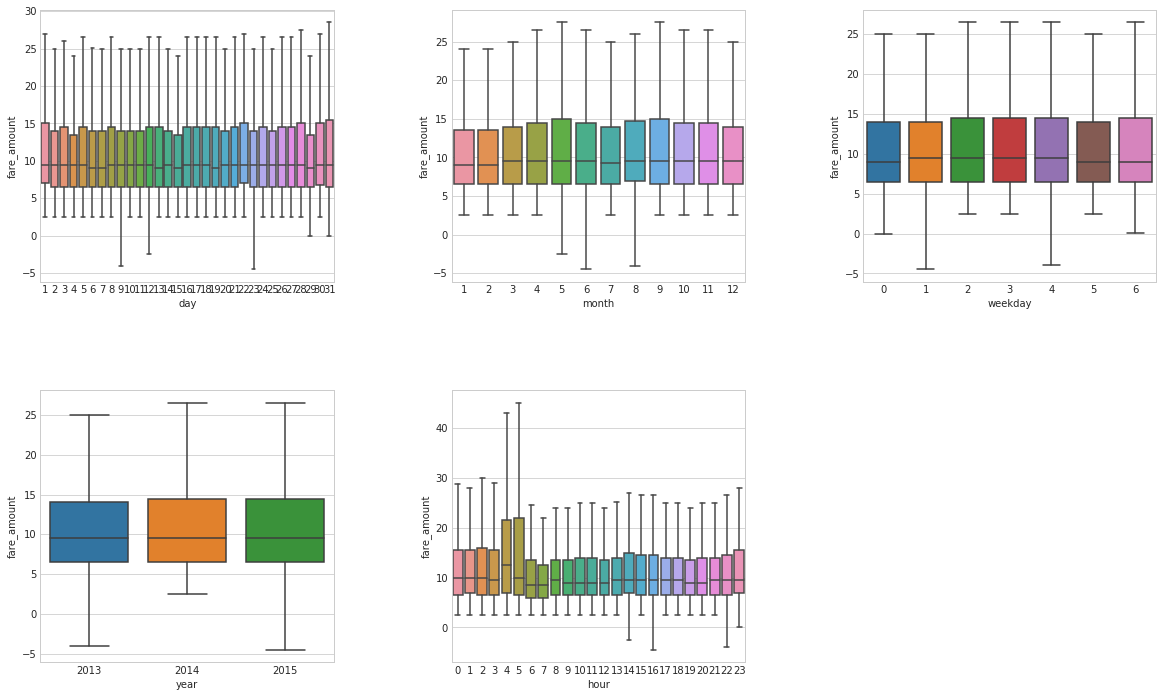

In [14]:
time_features = ['day', 'month', 'weekday', 'year', 'hour']

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(x=time_features[i], y="fare_amount", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

### Geographic 

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [15]:
nyc_box = (-74.1, -73.7, 40.6, 40.9)

In [16]:
def filter_coordinates(df, box):
    return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <=box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

In [17]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.1, lw=0.1, alpha=0.5)

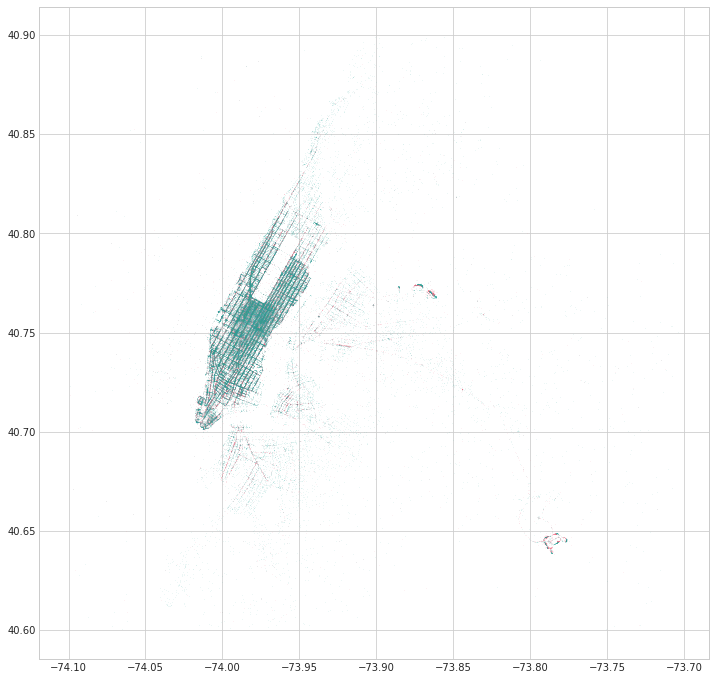

In [18]:
plot_hires(df_all, nyc_box)

<p>In the scatter plot above, the two major NYC airports are easily observed, indicating that it may be informative to "tell" our algorithm whether the ride starts or ends in an airport.</p>
<p>To do so I use the airports.csv, available <a href="http://ourairports.com/data/">here</a> in the following way:</p>
<ul>
<li>from this file I extract the location of 3 of the listed NYC airports</li>
<li>I than calculate the distance of dropoff and pickup points from every record to each airport, Assuming it will provide additional information to our model.</li>
</ul>
<p>Further details are in the feature extraction below</p>

## Ride distance 

In [19]:
df_all['air_distance'] = (df_all.pickup_longitude - df_all.dropoff_longitude)**2 +\
                     (df_all.pickup_latitude - df_all.dropoff_latitude)**2
df_all['air_distance'] = np.sqrt(df_all['air_distance'])

In [20]:
df_all['price_per_distance'] = df_all['fare_amount'] / df_all['air_distance']

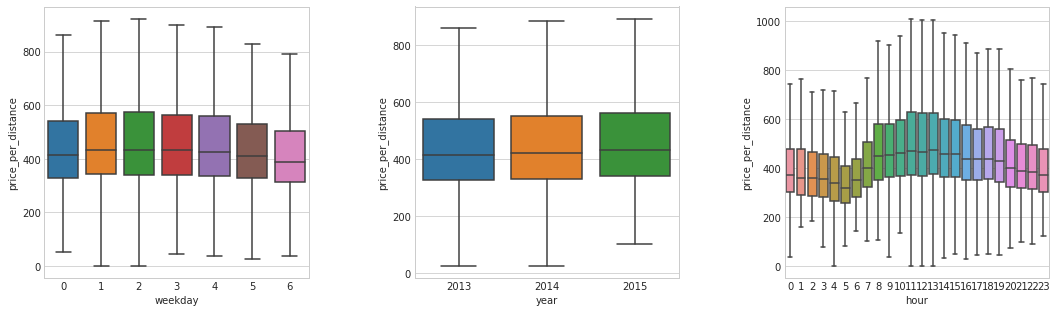

In [21]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="price_per_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

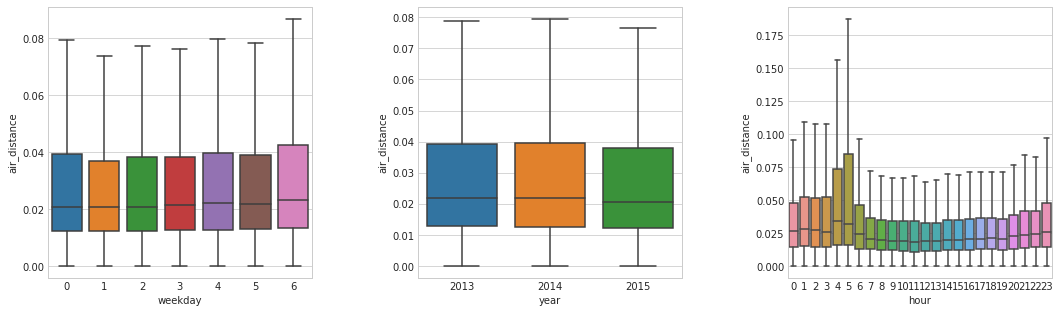

In [22]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="air_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

## Use Athena to extract features on all data

<p>As mentioned, the dataset we are working with contains 55M records, making its handling too heavy for a single machine.</p>
<p>Using a distributed computing engine like&nbsp;<a href="https://aws.amazon.com/athena/">AWS Athena</a>&nbsp;will enable you to extract features and save data efficiently.&nbsp;</p>
<p>In order to work on the data, we upload it to S3, and than partition it using AWS Glue. Partitioning is critical to make Athena run efficiently. For examples on how to use Glue, go&nbsp;<a href="https://github.com/doitintl/aws-glue-workshop">HERE</a>.</p>

### Extract features 

<p>With the data partitioned (say, by year and month), run the following Athena query to extract the following features&nbsp;</p>
<p>After extracting features, partition the query results using Glue (again)</p>

In [ ]:
SQL = '''
WITH 
    dataset AS 
    (SELECT CAST (pickup_datetime AS TIMESTAMP WITH time zone) AT TIME ZONE 'America/New_York' AS est, 
                  ST_POINT(pickup_longitude,pickup_latitude) pickup_point,
                  ST_POINT(dropoff_longitude,dropoff_latitude) dropoff_point,
                  to_unixtime( CAST (pickup_datetime AS TIMESTAMP WITH time zone) AT TIME ZONE 'America/New_York') AS                     epoch,
                  24*60*60 as seconds_in_day,
                  *
      FROM train_v3),
    
    airports AS (SELECT 
                  kv['LaGuardia'] AS LaGuardia,
                  kv['Downtown Manhattan/Wall St. Heliport'] AS Manhattan,
                  kv['John F Kennedy Intl'] AS JFK
    FROM (SELECT map_agg(name, point_location) kv
        FROM 
            (SELECT name,
         ST_POINT(longitude,
         latitude) point_location
            FROM usa_airports
            WHERE city = 'New York' )
            ))
        SELECT 
        
        -- Target
         fare_amount,
         
         -- time features
         day(est) day,
         day_of_week(est) dayofweek ,
         year(est) year ,
         month(est) month ,
         day_of_month(est) dayofmonth ,
         hour(est) hour ,
         minute(est) minute ,
         
         -- cyclclical variables
         sin(2*pi()*epoch/seconds_in_day) sin_day,
         cos(2*pi()*epoch/seconds_in_day) cos_day,
         sin(2*pi()*epoch/(seconds_in_day*7)) sin_week,
         cos(2*pi()*epoch/(seconds_in_day*7)) cos_week,
         
         
         -- Distance features
         pickup_longitude - dropoff_longitude diff_longitude,
         pickup_latitude - dropoff_latitude diff_latitude,
         ST_Distance(pickup_point, dropoff_point) dist,
         
         -- Airports features
         ST_DISTANCE(airports.LaGuardia, dropoff_point) dropoff_laguardia,
         ST_DISTANCE(airports.LaGuardia, pickup_point ) pickup_laguardia,
         ST_DISTANCE(airports.JFK, dropoff_point) dropoff_JFK,
         ST_DISTANCE(airports.JFK, pickup_point) pickup_JFK,
         ST_DISTANCE(airports.Manhattan, dropoff_point) dropoff_manhattan,
         ST_DISTANCE(airports.Manhattan, pickup_point) pickup_manhattan,
         
         -- Raw features
         pickup_longitude,
         pickup_latitude,
         dropoff_longitude,
         dropoff_latitude,
         passenger_count
         
    FROM dataset, airports
'''

## Split train test 

<p>If you managed to create the dataset using Athena, you have two options on how to create train and validation sets files.&nbsp;</p>
<ol>
<li>Create a seperate query, using a WHERE on the year clause to split the train and validation by time (e.g. year, month)</li>
<li>Create a single query, partition the results by time, and use aws-cli to mv the directories to different train/validation directotires</li>
</ol>

In [ ]:
# I used the second option
!aws s3 mv s3://athena-tmp-results/..../dataset/year=2015 s3://<my_bucket>/.../dataset/train/year=2015/
!aws s3 mv s3://athena-tmp-results/..../dataset/year=2014 s3://<my_bucket>/.../dataset/val/year=2014/

## Train model 

In [23]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime

In [24]:
path_train = os.path.join('sagemaker_demo','data_2','train')
path_val = os.path.join('sagemaker_demo','data_2','val')

In [25]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [26]:
s3_input_trains3_inpu  = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_train),
                                            content_type='csv',
                                            distribution='ShardedByS3Key')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_val),
                                         content_type='csv', 
                                         distribution='ShardedByS3Key')

In [27]:
sess = sagemaker.Session()
role = get_execution_role()

In [28]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

In [29]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=4, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
                                    sagemaker_session=sess)

In [30]:
's3://{}/{}/output'.format(bucket,training_job_path)

's3://kaggle-taxi-fare/training_jobs/2018-08-20-19-03-59/output'

In [31]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)


In [32]:
xgb.fit({'train': s3_input_trains3_inpu, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-08-20-19-04-07-244


........................
Arguments: train
[2018-08-20:19:07:55:INFO] Running distributed xgboost training.
Arguments: train
[2018-08-20:19:07:57:INFO] Running distributed xgboost training.
Arguments: train
[2018-08-20:19:07:57:INFO] Running distributed xgboost training.
[2018-08-20:19:07:59:INFO] Number of hosts: 4, master IP address: 10.44.0.3, host IP address: 10.40.0.3.
[2018-08-20:19:07:59:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-aws.out
[2018-08-20:19:07:59:INFO] Number of hosts: 4, master IP address: 10.44.0.3, host IP address: 10.44.0.3.
[2018-08-20:19:07:59:INFO] Finished Yarn configuration files setup.

[2018-08-20:19:07:59:INFO] Number of hosts: 4, master IP address: 10.44.0.3, host IP address: 10.47.0.3.
[2018-08-20:19:07:59:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-aws.out
Arguments: train
[2018-08-20:19:07:57:INFO] Runni


Billable seconds: 1418


## Deploy the model 

To deploy the model we move to the Amazon Sagemaker console and perform the following steps: <br>
1) Create model <br>
2) Create an endpoint configuration <br>
3) create and endpoint <br>

In [33]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-08-20-19-17-01-481
INFO:sagemaker:Creating endpoint with name xgboost-2018-08-20-19-04-07-244


---------------------------------------------------------------------------!

## Evaluate results 

Parts taken from here:<br>
https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [36]:
from sagemaker.predictor import csv_serializer

In [44]:
df_test = pd.read_csv('./df_val.csv', header=None)

In [94]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(df_test.as_matrix()[:, 1:])
predictions

array([4.58921766, 4.69809628, 7.8386693 , ..., 9.1456089 , 6.81339169,
       8.02333546])

In [47]:
df_val = pd.DataFrame()
df_val['prediction'] = predictions
df_val['target'] = df_test[0]

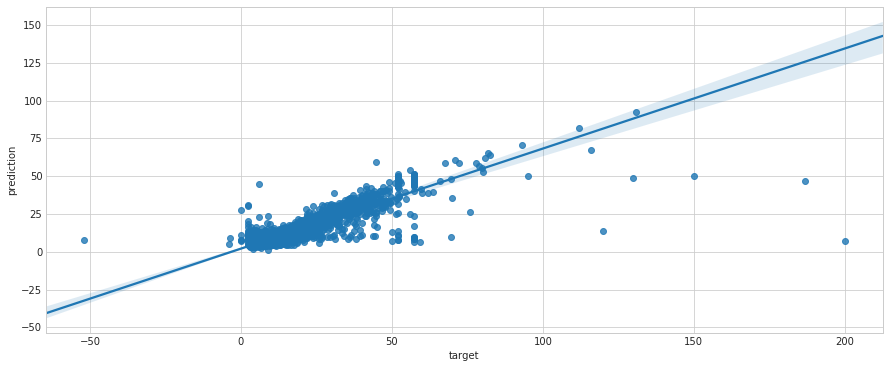

In [72]:
plt.figure(figsize=(15,6))
sns.regplot(x=df_val["target"], y=df_val["prediction"])
plt.show()

In [60]:
df_val['err'] = (df_val["target"] - df_val["prediction"])

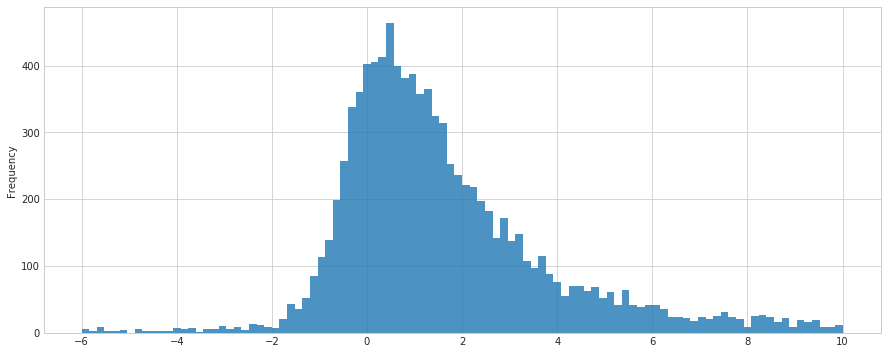

In [68]:
df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
plt.show()

In [133]:
df_val.describe()

,prediction,target,err
count,10000.000000,10000.000000,10000.000000
mean,10.136426,12.146189,2.009763
std,7.866508,10.783085,4.924559
min,1.217842,-52.000000,-60.065754
25%,5.855069,6.500000,0.157199
50%,7.719818,9.000000,1.156649
75%,10.799477,13.500000,2.742055
max,92.332817,200.000000,192.756607


## Make online predictions

In [129]:
import ast

In [130]:
csv_path = os.path.join('s3://', bucket, path_val, 'year=2015', 'month=4','run-1534713776930-part-r-00000')
df = pd.read_csv(csv_path, header=None)

n = 20
features = df.iloc[0:n,1:].values
values  = df.iloc[0:n,0].values

In [131]:
endpoint_name = 'xgboost-2018-08-20-19-04-07-244'
content_type = 'text/csv'
data = "\n".join(["\n".join([",".join(str(x) for x in sample)]) for sample in features])

runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                   ContentType='text/csv',\
                                   Body=data) 

In [132]:
result = list(ast.literal_eval(response['Body'].read().decode()))
print(result)

[42.3999252319, 6.63605451584, 8.07524490356, 7.78959321976, 5.41954421997, 15.7531328201, 6.93523740768, 8.32779502869, 17.6728153229, 8.15808486938, 8.18750667572, 5.9746928215, 20.5012798309, 6.00341939926, 6.62830781937, 6.69897270203, 6.00716352463, 6.65784788132, 7.12238788605, 11.7225542068]
